# Magnitude Estimation & Automatic Gain Control (AGC)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from rfproto import utils, agc_magest

Naively to get the instantaneous magnitude of a complex (I/Q) sample, one can use the Pythagorean theorem: $\sqrt{I^{2}+Q^{2}}$. However in high-throughput software code, the square-root operation is a very costly, iterative process; for instance, the AVX-512 SIMD intrinsic `_mm512_sqrt_ps` has an instruction latency of 19 cycles and- even worse- a CPI ([Cycles per Instruction](https://en.wikipedia.org/wiki/Cycles_per_instruction)) of 12 (ignoring the fact that it only supports floating-point data types as well). In digital HW (e.g. FPGA), the square root operation can be even more untenable.

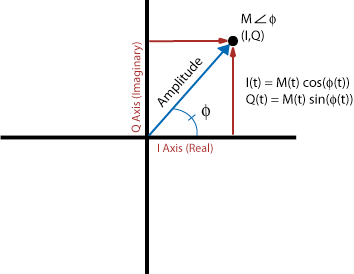

The _Alpha-Max Beta-Min estimator_ is an efficient, low-latency, low-resource magnitude estimator defined by:
$$ \text{Magnitude} \approx \alpha \cdot \text{max}(|I|, |Q|) + \beta \cdot \text{min}(|I|, |Q|) $$

It operates by:
> The absolute value operations folds the complex number into the range of 0-90 degrees, and the min, max operations further fold the complex number into the range of 0-45 degrees. Within this limited range, a linear combination of I and Q are a good approximation of magnitude.

The maximum and average magnitude estimation error (compared to floating-point truth) for different coefficients can be calculated as:

In [ ]:
# given phase wrapping of |theta|, need only test 0->45deg
test_phases = np.linspace(0, np.pi/4, 1025)
test_IQ     = np.cos(test_phases) + 1j*np.sin(test_phases)
test_mag    = np.abs(test_IQ)

peak_detect = agc_magest.alphaMax_betaMin(test_IQ, 1, 0)
a1_b1_2     = agc_magest.alphaMax_betaMin(test_IQ, 1, 0.5)
a1_b1_4     = agc_magest.alphaMax_betaMin(test_IQ, 1, 0.25)
a15_b15_32  = agc_magest.alphaMax_betaMin(test_IQ, 15/16, 15/32)
a15_b1_2    = agc_magest.alphaMax_betaMin(test_IQ, 15/16, 1/2)
# "closest geometric approximation" (minimum error) from: https://en.wikipedia.org/wiki/Alpha_max_plus_beta_min_algorithm
a0 = (2*np.cos(np.pi/8))/(1+np.cos(np.pi/8))
b0 = (2*np.sin(np.pi/8))/(1+np.cos(np.pi/8))
ab_min_err  = agc_magest.alphaMax_betaMin(test_IQ, a0, b0)

peak_detect_err = 100*(test_mag - peak_detect)/test_mag
a1_b1_2_err     = 100*(test_mag - a1_b1_2)/test_mag
a1_b1_4_err     = 100*(test_mag - a1_b1_4)/test_mag
a15_b15_32_err  = 100*(test_mag - a15_b15_32)/test_mag
a15_b1_2_err    = 100*(test_mag - a15_b1_2)/test_mag
ab_min_err_err  = 100*(test_mag - ab_min_err)/test_mag

# create zero mean error a0/b0 values
avg_a0b0_err = np.mean(ab_min_err_err/100)
a0_z0 = a0/(1 - avg_a0b0_err)
b0_z0 = b0/(1 - avg_a0b0_err)
ab_min_err_z0     = agc_magest.alphaMax_betaMin(test_IQ, a0_z0, b0_z0)
ab_min_err_err_z0 = 100*(test_mag - ab_min_err_z0)/test_mag

plt.plot(180*test_phases/np.pi, peak_detect_err, color='red',
         label=r"Peak Detect ($\alpha = 1, \beta = 0$)")
plt.plot(180*test_phases/np.pi, a1_b1_2_err, color='grey',
         label=r"$\alpha = 1, \beta = 1/2$")
plt.plot(180*test_phases/np.pi, a1_b1_4_err, color='blue',
         label=r"$\alpha = 1, \beta = 1/4$")
plt.plot(180*test_phases/np.pi, a15_b15_32_err, color='green',
         label=r"$\alpha = 15/16, \beta = 15/32$")
plt.plot(180*test_phases/np.pi, a15_b1_2_err, color='black',
         label=r"$\alpha = 15/16, \beta = 1/2$")
plt.plot(180*test_phases/np.pi, ab_min_err_err, color='purple',
         label=r"$\alpha = \alpha_{0}, \beta = \beta_{0}$")
plt.plot(180*test_phases/np.pi, ab_min_err_err_z0, color='orange', linestyle='dashed',
         label=r"$\alpha = \alpha_{0}, \beta = \beta_{0}$ (zero mean)")
plt.legend()
plt.title('Magnitude Estmation Error over Phase Angle')
plt.xlabel('Angle (degrees)')
plt.ylabel('Error Compared to True Magnitude (%)')
plt.show()

def print_err_stats(a: str, b: str, err: list[float]):
    print(f"Max (mean) error a={a}, b={b}: {max(abs(err)):.2f}% ({np.mean(err):.2f}%)")

print_err_stats('1', '0', peak_detect_err)
print_err_stats('1', '1/2', a1_b1_2_err)
print_err_stats('1', '1/4', a1_b1_4_err)
print_err_stats('15/16', '15/32', a15_b15_32_err)
print_err_stats('15/16', '1/2', a15_b1_2_err)
print_err_stats(str(a0), str(b0), ab_min_err_err)
print_err_stats(str(a0_z0), str(b0_z0), ab_min_err_err_z0)

Several observations can be seen based on various $\alpha,\beta$ coefficient values:
* In digital HW, a multiplier-less implementation can be achieved with fractional coefficients such as $\alpha = 1$ and $\beta = 1/4$; dividing a value by $2^{N}$ is simply achieved by right-shifting a value by $N$ bits.
* The geometric coefficients of $\alpha_{0} = \frac{2\cos(\pi/8)}{1+\cos(\pi/8)}, \quad \beta_{0} = \frac{2\sin(\pi/8)}{1+\cos(\pi/8)}$ have the lowest overall error, but require two multipliers.
* Moreover, in an algorithm which averages, or accumulates, these values over time (e.x. in an Automatic Gain Control (AGC) loop), it's desirable to have coefficients with zero mean error, such that over time the overall error goes to 0. These are the last coefficients found by using the lowest error geometric coefficients and removing the mean bias over the sweep of phase values $0 \rightarrow \pi/4$

To find the associated `short` (signed 16 bit integer) values of these coefficients:

In [ ]:
# scale a0/b0 decimal values -> FXP integer
bit_width = 16

# Q0.15 format so bit_width - 1 is # of fractional bits
# Golden 15b values: a0_fxp = 31068, b0_fxp = 12870
a0_fxp = utils.dbl_to_fxp(a0_z0, bit_width - 1)
# In testing, +1 to b0 actually gives slightly lower error w/mulhrs rounding scheme
b0_fxp = utils.dbl_to_fxp(b0_z0, bit_width - 1) + 1
print(f"{bit_width}b FXP a0 = {a0_fxp}, b0 = {b0_fxp}")

### Average Error over Time

We can show that over time, these coefficients average out to zero error next.

**NOTE:** In `numpy` the `abs()` function computes the magnitude of each complex sample as in $\sqrt{i^{2} + q^{2}}$. The floating-point value is then rounded, to match integer representation of fixed-point values.

In [ ]:
true_avg = 0 # true, running average of real mag values, calculated after each iteration
est_avg  = 0 # running average based on magnitude estimation method

N = 1024 # number of I/Q samples to show convergence
mag_est_phase     = np.zeros(N, dtype=np.int32) # est. magnitude values
mag_est_phase_err = np.zeros(N)                 # accumulation of error average magnitudes
mag_true_phase    = np.zeros(N)

# simulate FXP SIMD mag est. math (e.g. _mm512_mulhrs_epi16 instruction) using scaled a0/b0 constants
def mulhrs(iq_samp: complex, a_fxp: int, b_fxp: int) -> int:
    # create intermediate 32b value
    int_prod = a_fxp*max(abs(iq_samp.real), abs(iq_samp.imag)) + b_fxp*min(abs(iq_samp.real), abs(iq_samp.imag))
    # model rounding & final scaling (keep only lower 16 LSBs) 
    return ((int(int_prod) >> 14) + 1) >> 1

for i in range(N):
    # calculate across all phase angles
    temp_phase = i*(np.pi/100)
    temp_IQ    = np.cos(temp_phase) + 1j*np.sin(temp_phase)
    temp_IQ    = np.round(temp_IQ * (2**15))
    
    mag_true_phase[i] = np.abs(temp_IQ)
    true_avg = np.sum(mag_true_phase[:i+1])/(i+1)
    
    mag_est_phase[i]= mulhrs(temp_IQ, a0_fxp, b0_fxp)
    est_avg = np.sum(mag_est_phase[:i+1])/(i+1)
    if true_avg: # check for /0
        mag_est_phase_err[i] = 100*(est_avg - true_avg)/true_avg
    else:
        mag_est_phase_err[i] = 0

plt.title('Average FXP Magnitude Estmation Error over Sample Count')
plt.xlabel('Average Magnitude Estimation Sample Size')
plt.ylabel('Error to True Average Magnitude (%)')
plt.plot(mag_est_phase_err,
         label=r"$0 \leq \theta \leq \pi/4$")
plt.legend()
plt.show()

conv_err = np.mean(mag_est_phase_err[-10:-1])
print(f"Converged error over accumulated averages: {conv_err:.6f}%")
print(f"Error quantized to 15b magnitude: {(conv_err/100)*(2**15):.6f}\n")

### Received Signal Strength Indication (RSSI) 

With $N$ number of magnitude estimation values, the average magnitude can be found, which also models the discrete-time energy computation of:

$$ E[x] = \frac{1}{N}\sum|x^{2}| $$

Given the above average magnitude calculation ($\approx I^{2} + Q^{2}$), we can convert to a dBFS (dB full-scale) value by taking $20\log_{10}()$ of the normalized magnitude (e.g. magnitude calculation divided by full-scale integer/FXP value).

## References

* [Alpha Max plus Beta Min Algorithm - Wikipedia](https://en.wikipedia.org/wiki/Alpha_max_plus_beta_min_algorithm)
* [Magnitude Estimator - DSP Guru](https://dspguru.com/dsp/tricks/magnitude-estimator/)